In [1]:
from nltk import TweetTokenizer
from pandas import DataFrame
from datetime import datetime,timedelta
from matplotlib import pyplot as plt
from numpy import arange,subtract,divide
import pymorphy2
import rulemma
import rupostagger
import re
from string import punctuation
from stop_words import get_stop_words
from collections import defaultdict, OrderedDict

In [2]:
def cutter(twit):
    twit = re.sub(r'http\S+|pic.twitter\S+', '',twit)
    twit = twit.translate(str.maketrans(stopSymbols, ' ' * 31))
    return twit

In [3]:
print("START")
approved = ["СУЩЕСТВИТЕЛЬНОЕ","ПРИЛАГАТЕЛЬНОЕ","ГЛАГОЛ","НАРЕЧИЕ","ДЕЕПРИЧАСТИЕ"]
stopwords = get_stop_words('russian')
stopSymbols = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'
tweets = []
yearRegexp = '2018'      
monthRegexp = '(0[1-9]|1[0-2])'              
dayRegexp = '(0[1-9]|1[0-9]|2[0-9]|3[0-1])'   
hourRegexp = '([0-1][0-9]|2[0-3])'   
minRegexp = '([0-5][0-9])'            
dataRegexp = r"^{}-{}-{} {}:{}".format(yearRegexp,monthRegexp,dayRegexp,hourRegexp,minRegexp)

totalTweets = 0
uniqWords = {}
bogoslens = defaultdict(int)
truelens = defaultdict(int)

lemmatizer = rulemma.Lemmatizer()
lemmatizer.load()

tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True,preserve_case = False)

tagger = rupostagger.RuPosTagger()
tagger.load()

with open("data.txt","r",encoding="utf-8") as data:
    for twit in data:
        if twit == "\n" : continue
        totalTweets += 1
        twitLen = 0
        checkedLemmas = []
        twitTime = re.search(dataRegexp,twit)
        twit = cutter(twit)
        tokens = tokenizer.tokenize(twit)
        tags = tagger.tag(tokens)
        lemmas = lemmatizer.lemmatize(tags)
        for lemmatized in lemmas:
            word = lemmatized[2]
            partOfSpeech = lemmatized[3]
            if len(word) > 2 and partOfSpeech in approved and word not in stopwords and word not in checkedLemmas and bool(re.fullmatch(r'[а-яa-z]*', word)):
                checkedLemmas.append(word)
                dictWord = uniqWords.get(word,[0,partOfSpeech])
                dictWord[0]+=1
                uniqWords[word] = dictWord
                twitLen+=1
            elif word == "не":
                checkedLemmas.append(word)
            elif word in checkedLemmas:
                checkedLemmas.append(word)
                twitLen+=1
            
        bogoslens[len(tokens)]+=1
        truelens[twitLen]+=1
        if twitLen and twitTime: 
            tweets.append([twitTime.group(),checkedLemmas])
print("READY")             

START
READY


In [4]:
with open("estimations.txt","r",encoding="utf-8") as estimations:
    parsedEstimations = {x[0]:int(x[1]) for x in [wordLine.split(' ') for wordLine in estimations.read().splitlines()]}
    for word in uniqWords:
        access = parsedEstimations.get(word,None)
        if access:
            uniqWords[word].append(int(access))
        else:
            uniqWords[word].append(0)

In [5]:
with open("true_twits_length.txt","w",encoding="utf-8") as lengthsFile:
    for length,timesMet in sorted(truelens.items(),key = lambda i:i[1],reverse=True):
        lengthsFile.write("{}-{}-{}%\n".format(length,timesMet,timesMet/totalTweets))

In [6]:
with open("bogos_twits_length.txt","w",encoding="utf-8") as lengthsFile:
    for length,timesMet in sorted(bogoslens.items(),key = lambda i:i[1],reverse=True):
        lengthsFile.write("{}-{}-{}%\n".format(length,timesMet,timesMet/totalTweets))

In [7]:
with open("frequencies.txt","w",encoding="utf-8") as freqFile:
    for word,wordInfo in sorted(uniqWords.items(),key = lambda i:i[1][0],reverse=True):
        freqFile.write("{}-{}-{}%\n".format(word,wordInfo[0],wordInfo[0]/totalTweets))

In [8]:
positive = []
negative = []
morph = pymorphy2.MorphAnalyzer()
for word,wordInfo in sorted(uniqWords.items(),key = lambda i:i[1][0],reverse=True):
    if wordInfo[1] == "ПРИЛАГАТЕЛЬНОЕ" and morph.parse(word)[0].tag.POS == "ADJF" and (len(negative)!=5 or len(positive)!=5):
        if wordInfo[2] == -1 and len(negative)<5:
            negative.append([word,wordInfo[0]])
        elif wordInfo[2] == 1 and len(positive)<5:
            positive.append([word,wordInfo[0]])
with open("adjectives.txt","w",encoding="utf-8") as adjectives:
    adjectives.write("Top-5 Positive:\n")
    for word in positive:
        adjectives.write("{}-{}-{}%\n".format(word[0],word[1],word[1]/totalTweets))
    adjectives.write("\nTop-5 Negative:\n")
    for word in negative:
        adjectives.write("{}-{}-{}%\n".format(word[0],word[1],word[1]/totalTweets))

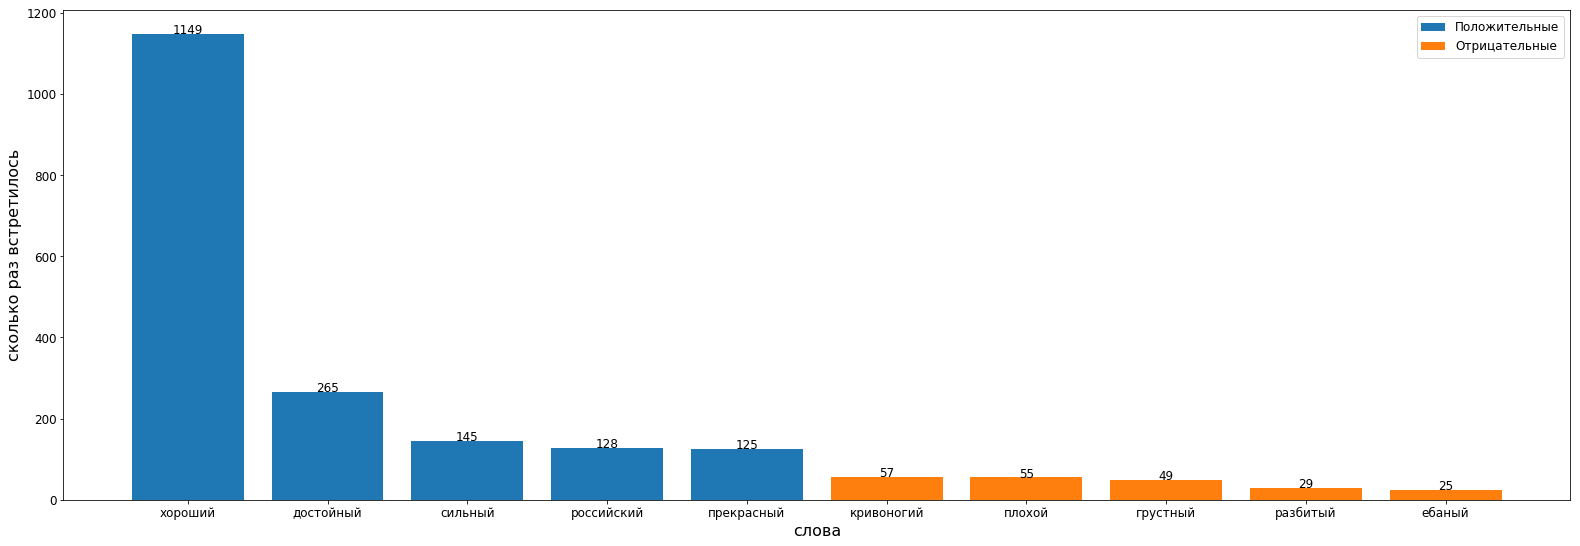

In [9]:
def annotator(XX,YY,plot,mode = False):
    r = 0 if mode == False else 90
    for x,y in zip(XX,YY):
        plot.annotate(y, # this is the text
                    (x,y), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    rotation = r,
                    color = "black",
                    va = "top",
                    ha='center') # horizontal alignment can be left, right or center

plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = [27,9]
plt.xlabel('слова',fontsize = 16)
plt.ylabel('сколько раз встретилось',fontsize = 16)
xpos = [word[0] for word in positive]
xneg = [word[0] for word in negative]
ypos = [word[1] for word in positive]
yneg = [word[1] for word in negative]
plt.bar(xpos,ypos,label="Положительные")
plt.bar(xneg,yneg,label="Отрицательные")
annotator(xpos,ypos,plt)
annotator(xneg,yneg,plt)

plt.legend()
plt.show()

In [10]:
rule1arr = [0,0,0]
rule2arr = [0,0,0]
rule3arr = [0,0,0]
rule4arr = [0,0,0]
goodWords = [x[0] for x in sorted(uniqWords.items(),key = lambda i:i[1],reverse=True) if x[1][2] == 1]
badWords = [x[0] for x in sorted(uniqWords.items(),key = lambda i:i[1],reverse=True) if x[1][2] == -1]

def rule1(access,arr):
    access = [0,0,0]
    flag = False
    for word in twit[1]:     
        if word == "не":
            flag = True
            continue    
        score = -uniqWords[word][2] if flag else uniqWords[word][2]
        access[score+1]+=1
        flag = False
        
    score = sum([(x[0] - 1) * x[1] for x in enumerate(access)])
    if score > 1:
        arr[2]+=1
    elif score < -1:
        arr[0]+=1
    else:
        arr[1]+=1

def rule2(twit,arr):
    access = [0,0,0]
    flag = False
    for word in twit[1]:     
        if word == "не":
            flag = True
            continue    
        score = -uniqWords[word][2] if flag else uniqWords[word][2]
        access[score+1]+=1
        flag = False
    
    
    maxA = max(access)
    if maxA == access[2] != 0:
        arr[2] += 1 #случай когда положительных == отрицательных
    elif maxA != 0:
        arr[access.index(max(access))] += 1
    else:#твит с одним не
        arr[1] += 1
        
def rule3(twit,arr):
    access = [0,0,0]
    flag = False
    for word in twit[1]:
        isRude = word in rudeWords     
        if word == "не":
            flag = True
            continue    
        score = -uniqWords[word][2] if flag else uniqWords[word][2]
        if isRude:
            access[0] += 2
        else:
            access[score+1]+=1
        flag = False
        
    score = sum([(x[0] - 1) * x[1] for x in enumerate(access)])
    if score > 1:
        arr[2]+=1
    elif score < -1:
        arr[0]+=1
    else:
        arr[1]+=1
    
    
def rule4(twit,arr):
    access = [0,0]
    flag = False
    for word in twit[1]:
        if word == "не":
            flag = True
            continue
        score = uniqWords[word][2]
        if score == 1:
            score = -score if flag else score
            score = score / (goodWords.index(word) + 1)
        elif score == -1:
            score = -score if flag else score
            score = score / (badWords.index(word) + 1)
            
        if score < 0:
            access[0] +=score
        elif score > 0:
            access[1] +=score
        flag = False
        
    delta = access[1] + access[0]
    if delta < -0.07:
        arr[0]+=1
    elif delta > 0.07:
        arr[2]+=1
    else:
        arr[1]+=1

In [11]:
file = open("rude_words.txt","r",encoding="utf-8")
rudeWords = file.read().splitlines()
file.close()
for twit in tweets:        
    rule1(twit,rule1arr)
    rule2(twit,rule2arr)
    rule3(twit,rule3arr)
    rule4(twit,rule4arr)

totalSignTweets = sum(rule1arr)
with open("classifications.txt","w",encoding="utf-8") as classifications:
    labels = ("Bad","Neutral","Good")
    classifications.write("Интервальное правило\n")
    for i,access in enumerate(rule1arr):
        classifications.write("{0}-{1}-{2:.3f}%\n".format(labels[i],access,access/totalSignTweets))
    classifications.write("\nПравило максимальной встречаемости\n")
    for i,access in enumerate(rule2arr):
        classifications.write("{0}-{1}-{2:.3f}%\n".format(labels[i],access,access/totalSignTweets))
    classifications.write("\nПравило влияния грубых слов\n")
    for i,access in enumerate(rule3arr):
        classifications.write("{0}-{1}-{2:.3f}%\n".format(labels[i],access,access/totalSignTweets))
    classifications.write("\nПравило влияния частоты слова\n")
    for i,access in enumerate(rule4arr):
        classifications.write("{0}-{1}-{2:.3f}%\n".format(labels[i],access,access/totalSignTweets)) 


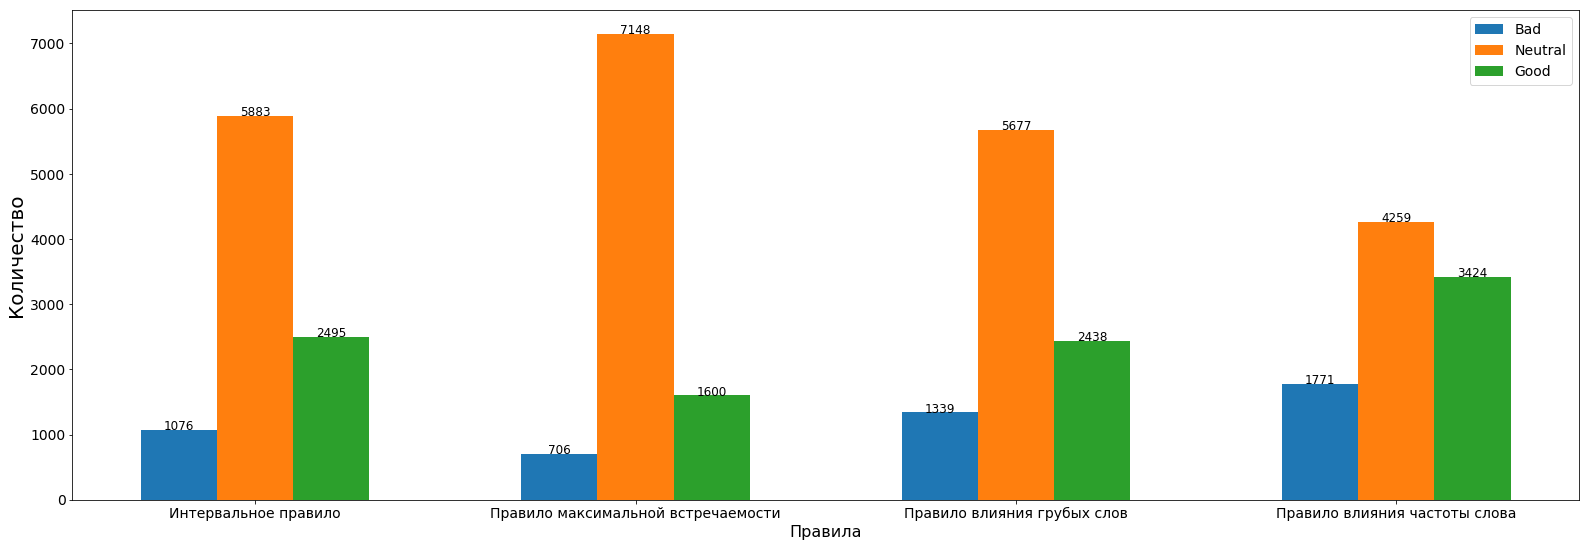

[1076, 5883, 2495]
[706, 7148, 1600]
[1339, 5677, 2438]
[1771, 4259, 3424]


In [12]:
goodstat = [x[2] for x in [rule1arr,rule2arr,rule3arr,rule4arr]]
badstat = [x[0] for x in [rule1arr,rule2arr,rule3arr,rule4arr]]
neutralstat = [x[1] for x in [rule1arr,rule2arr,rule3arr,rule4arr]]
width = 0.2
ind = arange(len(goodstat))    
plt.bar(ind, badstat, width, label='Bad')
plt.bar(ind + width, neutralstat, width, label='Neutral')
plt.bar(ind + 2*width, goodstat, width, label='Good')
annotator(ind, badstat,plt)
annotator(ind + width, neutralstat,plt)
annotator(ind + 2*width, goodstat,plt)
plt.ylabel('Количество',fontsize = 20)
plt.xlabel('Правила',fontsize = 16)
plt.rcParams["figure.figsize"] = [27,9]
plt.rcParams["font.size"] = 14
plt.xticks(ind + width, ('Интервальное правило', 'Правило максимальной встречаемости', 'Правило влияния грубых слов', 'Правило влияния частоты слова'),fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(loc='best')
plt.show()

print(rule1arr)
print(rule2arr)
print(rule3arr)
print(rule4arr)

In [13]:
delta = 15
tweets = sorted(tweets,key = lambda twit:datetime.strptime(twit[0], '%Y-%m-%d %H:%M'))
rightB = datetime.strptime(tweets[0][0], '%Y-%m-%d %H:%M') + timedelta(minutes=delta)
result = defaultdict(list)


information = [0,0,0]
for twit in tweets:
    flag = False
    while datetime.strptime(twit[0], '%Y-%m-%d %H:%M') > rightB:
        flag = True
        rightB += timedelta(minutes=delta)
        
    if flag == True:
        time = rightB.strftime('%Y-%m-%d %H:%M').split(' ')
        result[time[0]].append([time[1],information[:]])
    
    rule1(twit,information)  
    flag = False

time = rightB.strftime('%Y-%m-%d %H:%M').split(' ')
if result:
    result[time[0]][-1] = [time[1],information[:]]
else:
    result[time[0]].append([time[1],information[:]])

result = OrderedDict(sorted(result.items()))

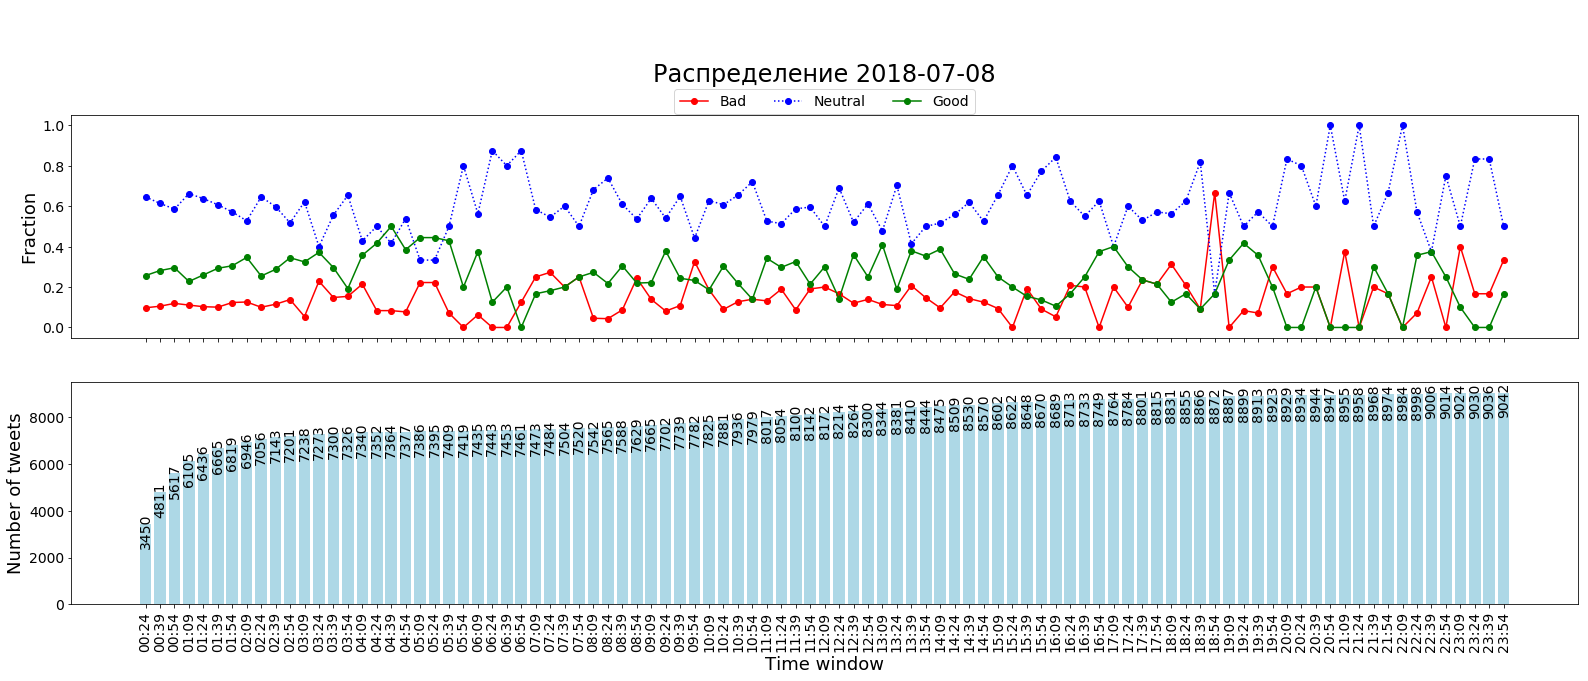

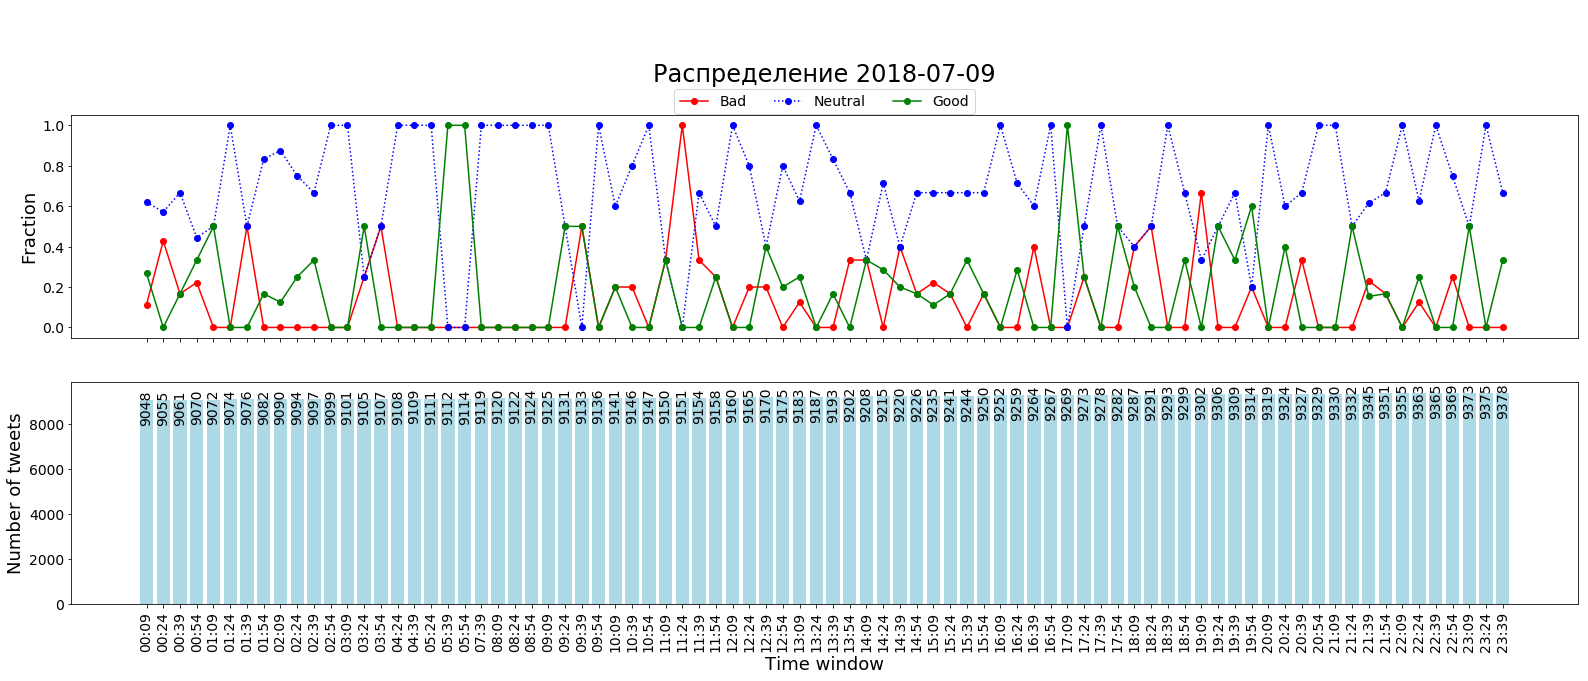

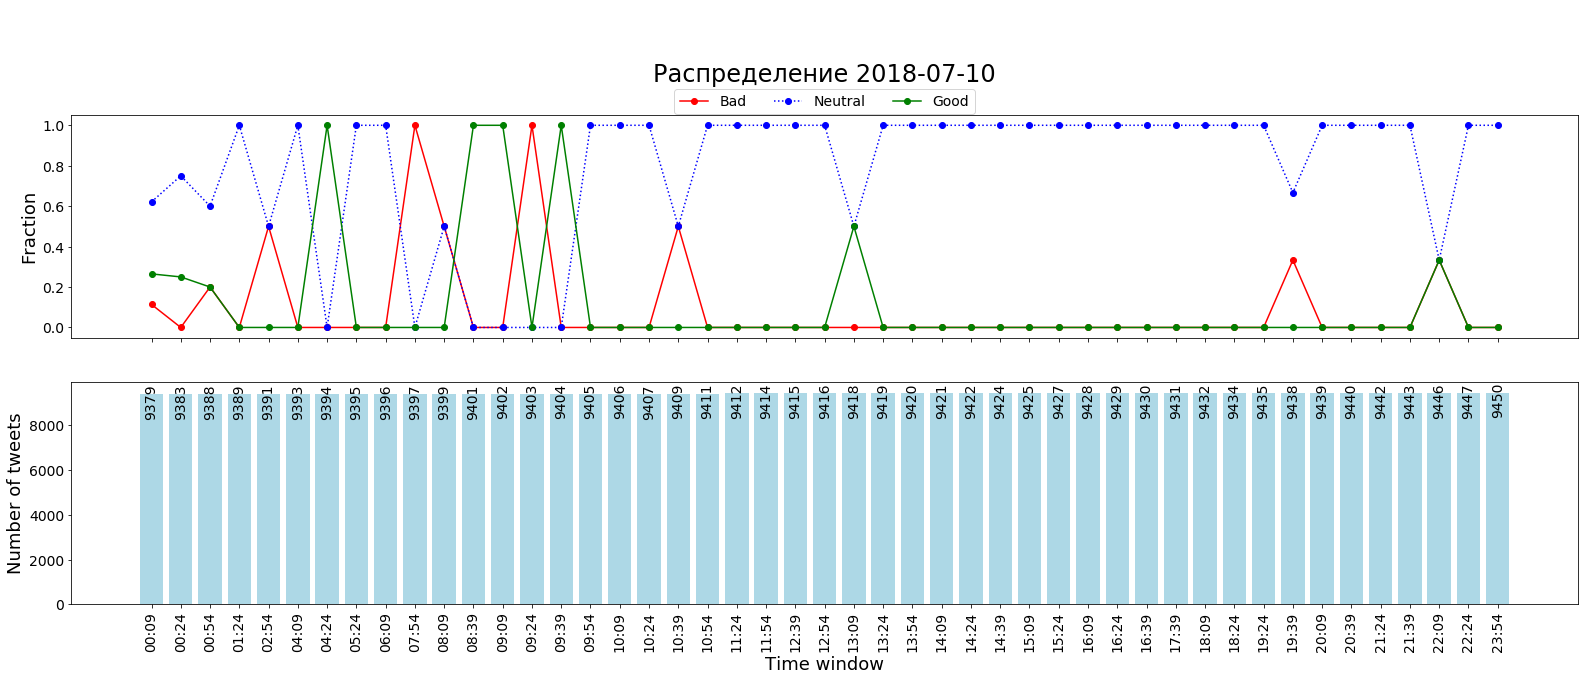

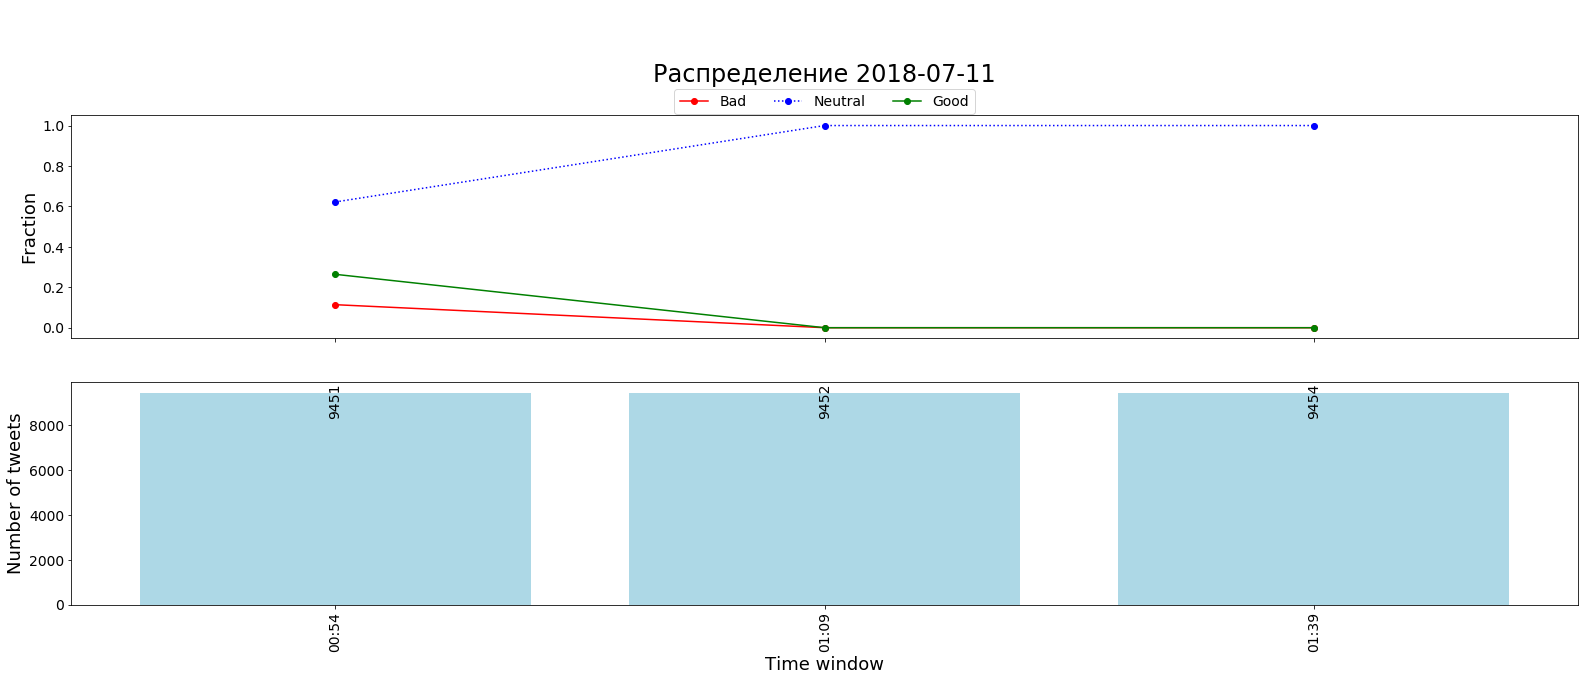

In [14]:
file = open("hours.txt","w",encoding="utf-8")
flag = False
for championshipDay in result:
    file.write('{}-------{}-------\n'.format('\n' if flag == True else '',championshipDay))
    flag = True
    delta = [0,0,0]
    x = [x[0] for x in result[championshipDay]]
    f, (ax1, ax2) = plt.subplots(2, 1,sharex = True)
    y = []
    
    for time in result[championshipDay]:
        substracted = subtract(time[1],delta)
        divided = list(divide(substracted,sum(substracted))) 
        y.append(divided)
        file.write("{} {} {}\n".format(time[0],sum(substracted),'/'.join( [str(round(x,2)) for x in divided] ) ))
        
        delta = time[1]
        
    ax1.plot(x,[p[0] for p in y],'-ro',label="Bad")
    ax1.plot(x,[p[1] for p in y],':bo',label="Neutral")
    ax1.plot(x,[p[2] for p in y],'-go',label="Good")
    ax1.set_ylabel("Fraction",fontsize = 18)
    ax1.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol = 3,fontsize = 14)
    ax1.set_title("\n\nРаспределение {}\n".format(championshipDay),fontsize = 24)
    plt.sca(ax1)
    plt.yticks(fontsize = 14)
    
    y = [sum(y[1]) for y in result[championshipDay]]
    ax2.bar(x,y,color = "lightblue")
    annotator(x,y,ax2,True)
    ax2.set_xlabel("Time window",fontsize = 18)
    ax2.set_ylabel("Number of tweets",fontsize = 18)
    plt.sca(ax2)
    plt.xticks(rotation = 90,fontsize = 14)
    plt.yticks(fontsize = 14)

file.close()

In [15]:
def TwitAccesser(twit):
    access = 0
    count = 0
    for word in twit:  
        word = uniqWords.get(word,None)
        if word :
            access += word[2]
            count +=1
    
    return access / count

for twit in tweets:
    twitAccess = TwitAccesser(twit[1])
    for word in twit[1]:
        UWword = uniqWords.get(word,None)
        if not UWword:
            continue
        elif len(UWword) < 4:
            uniqWords[word].append(twitAccess)
        else:
            uniqWords[word][3] += twitAccess

In [19]:
uniqWords['взаимопонимание'].append(0.25)

In [20]:
for word in uniqWords:
    uniqWords[word][3] = uniqWords[word][3]/uniqWords[word][0]

In [21]:
d2 = OrderedDict(sorted(uniqWords.items(),key = lambda word: abs(word[1][3] - word[1][2]), reverse = False))
items = list(d2.items())
trueEst = len([False for word in uniqWords.values() if abs(word[3] - word[2]) < 0.15])

with open ("estimation_check.txt","w",encoding="utf-8") as file:
    file.write("Top 5 Closest\n")
    for i in range(5):
        file.write('{0} {1}/{2:.2f}\n'.format(items[i][0],items[i][1][2],items[i][1][3]))
    file.write("\nTop 5 Furthest\n")
    for i in range(5):
        file.write('{0} {1}/{2:.2f}\n'.format(items[len(items) - i - 1][0],items[len(items) - i - 1][1][2],items[len(items) - i - 1][1][3]))
    file.write("\nEstimation accurancy: {0:.3f}%".format(trueEst /len(uniqWords)*100))

In [22]:
d2 = OrderedDict(sorted(uniqWords.items(),key = lambda word: word[1][3], reverse = True))
items = list(d2.items())

with open ("best_worst.txt","w",encoding="utf-8") as file:
    file.write("Top 5 positive\n")
    for i in range(5):
        file.write('{0} - {1:.2f}\n'.format(items[i][0],items[i][1][3]))
    file.write("\nTop 5 negative\n")
    for i in range(5):
        file.write('{0} - {1:.2f}\n'.format(items[len(items) - i - 1][0],items[len(items) - i - 1][1][3]))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

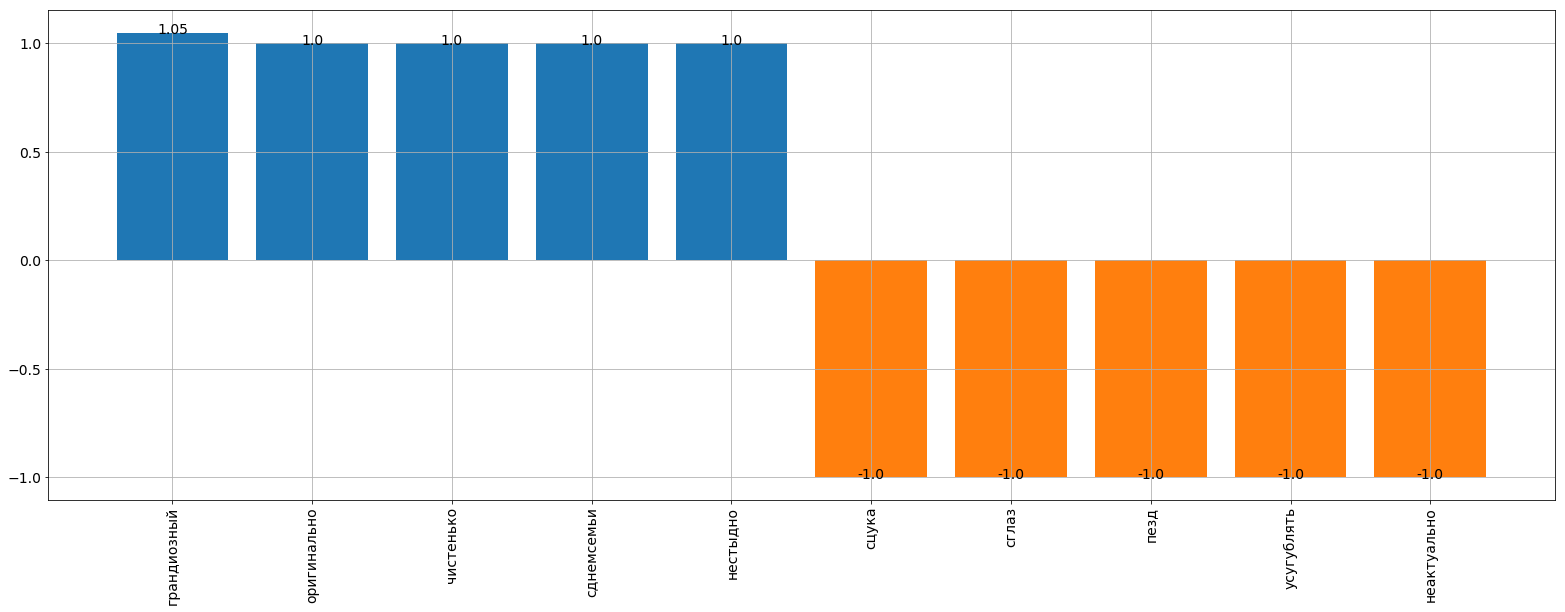

In [23]:
x = [x[0] for x in items[:5]]
y = [round(y[1][3],2) for y in items[:5]]
plt.bar(x,y)
annotator(x,y,plt)

x = [x[0] for x in items[-5:]]
y = [round(y[1][3],2) for y in items[-5:]]
plt.bar(x,y)
annotator(x,y,plt)
plt.grid(True)
plt.xticks(rotation = 90)